In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from markowitz import Data, Parameters, markowitz
from experiments.utils import synthetic_returns
from experiments.backtest import interest_and_fees, OptimizationInput, create_orders, execute_orders, Timing, BacktestResult, run_markowitz

from tuning import HyperParameters, get_data_and_parameters, full_markowitz

# autoreload modules
%load_ext autoreload
%autoreload 2

In [2]:
steps = 750

prices = pd.read_csv("../data/prices.csv", index_col=0, parse_dates=True).iloc[:]
spread = pd.read_csv("../data/spreads.csv", index_col=0, parse_dates=True).iloc[:]
volume = pd.read_csv("../data/volumes.csv", index_col=0, parse_dates=True).iloc[:]
rf = pd.read_csv("../data/rf.csv", index_col=0, parse_dates=True).iloc[:, 0].iloc[:]
# returns = prices.pct_change().dropna()

train_len = 1250
test_len = 500

# -500 since first 500 re discarded in backtest
prices_train = prices.iloc[-train_len-test_len-500:-test_len]
prices_test = prices.iloc[-test_len-500:]
spread_train = spread.iloc[-train_len-test_len-500:-test_len]
spread_test = spread.iloc[-test_len-500:]
volume_train = volume.iloc[-train_len-test_len-500:-test_len]
volume_test = volume.iloc[-test_len-500:]
rf_train = rf.iloc[-train_len-test_len-500:-test_len]
rf_test = rf.iloc[-test_len-500:]

returns_train = prices_train.pct_change().dropna()
returns_test = prices_test.pct_change().dropna()

n_assets = prices.shape[1]

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

(0.0, 1.0)

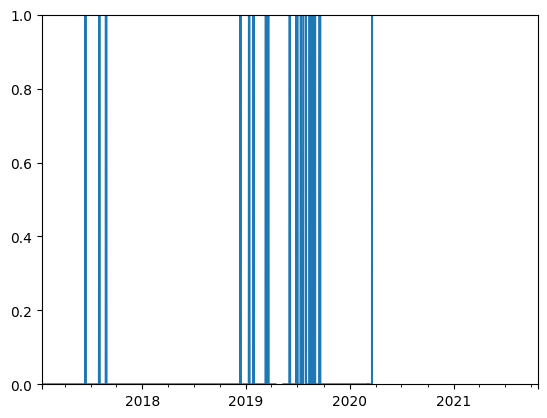

In [49]:
duals.Risk.plot()
plt.ylim(0,1)

In [15]:
from collections import namedtuple

def tune_parameters(
    strategy,
    prices,
    spread,
    volume,
    rf,
    risk_target,
    verbose=True,
):  
    def run_strategy(hyperparameters):
        results, duals = run_markowitz(
            strategy,
            prices,
            spread,
            volume,
            rf,
            risk_target,
            hyperparameters,
            verbose=False,
        )
        return results, duals

    # gamma_hold, gamma_trade, gamma_turn, gamma_leverage, gamma_risk
    hyperparameters = HyperParameters(
        0, 0, 0, 0, 0
        )
    # First find reasonable soft constraing parameters

    if verbose:
        print("Tuning soft constraint parameters")
    results, duals = run_strategy(hyperparameters)
    gamma_risk = duals.Risk.quantile(0.9)
    gamma_turn = duals.Turnover.quantile(0.9)
    gamma_leverage = duals.Leverage.quantile(0.9)

    # # tune gamma_hold and gamma_trade

    gamma_hold_trade = namedtuple("gamma_hold_trade", ["gamma_hold", "gamma_trade"])
    gamma_hold_trade.gamma_hold = 1
    gamma_hold_trade.gamma_trade = 1

    parameters_to_results = {}
    parameters_to_results["hard"] = (hyperparameters, results, duals)
    print(f"SR with hard constraints: {results.sharpe}")


    # solve the soft constraint problem for gamma_hold and gamma_trade
    hyperparameters = HyperParameters(
        gamma_hold_trade.gamma_hold, gamma_hold_trade.gamma_trade, gamma_turn, gamma_leverage, gamma_risk
    )
    results, _ = run_strategy(hyperparameters)
    parameters_to_results[0] = (hyperparameters, results)
    print(f"SR: {results.sharpe}")

    sharpe_old = results.sharpe

    iteration = 0
    while True: 
        print(f"Iteration number {iteration}; current sharpe: {sharpe_old}")
        if iteration % 2 == 0:
            gamma_hold_temp = gamma_hold_trade.gamma_hold * 1.5

            hyperparameters = HyperParameters(
                gamma_hold_temp, gamma_hold_trade.gamma_trade, gamma_turn, gamma_leverage, gamma_risk
            )
            results, duals = run_strategy(hyperparameters)
            if results.sharpe > sharpe_old:
                gamma_hold_trade.gamma_hold = gamma_hold_temp
                sharpe_old = results.sharpe
            else:
                gamma_hold_temp = gamma_hold_trade.gamma_hold * 0.5
                hyperparameters = HyperParameters(
                    gamma_hold_temp, gamma_hold_trade.gamma_trade, gamma_turn, gamma_leverage, gamma_risk
                )
                results, _ = run_strategy(hyperparameters)
                if results.sharpe > sharpe_old:
                    gamma_hold_trade.gamma_hold = gamma_hold_temp
                    sharpe_old = results.sharpe
                else:
                    if iteration > 0:
                        break
        elif iteration % 2 == 1:
            gamma_trade_temp = gamma_hold_trade.gamma_trade * 1.5

            hyperparameters = HyperParameters(
                gamma_hold_trade.gamma_hold, gamma_trade_temp, gamma_turn, gamma_leverage, gamma_risk
            )
            results, _ = run_strategy(hyperparameters)
            if results.sharpe > sharpe_old:
                gamma_hold_trade.gamma_trade = gamma_trade_temp
                sharpe_old = results.sharpe
            else:
                gamma_trade_temp = gamma_hold_trade.gamma_trade * 0.5
                hyperparameters = HyperParameters(
                    gamma_hold_trade.gamma_hold, gamma_trade_temp, gamma_turn, gamma_leverage, gamma_risk
                )
                results, _ = run_strategy(hyperparameters)
                if results.sharpe > sharpe_old:
                    gamma_hold_trade.gamma_trade = gamma_trade_temp
                    sharpe_old = results.sharpe
                else:
                    if iteration > 0:
                        break
                        
            parameters_to_results[iteration] = (hyperparameters, results)

        iteration += 1

    
    return parameters_to_results


    

    

In [17]:
parameter_dict = tune_parameters(
    full_markowitz,
    prices_train,
    spread_train,
    volume_train,
    rf_train,
    0.1/np.sqrt(252),
    verbose=True,
)

Tuning soft constraint parameters
SR with hard constraints: 0.5310964818894202
SolverError
None
SolverError
None


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1395: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SR: 0.907885694576923
Iteration number 0; current sharpe: 0.907885694576923
SolverError
None
SolverError
None
SolverError
None


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1395: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1395: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
Iteration number 1; current sharpe: 0.907885694576923
SolverError
None
SolverError
None


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1395: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1395: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
Iteration number 2; current sharpe: 1.3857211445220385


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1395: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1395: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None
SolverError
None


In [25]:
params = [*parameter_dict.values()][-1][0]
res = [*parameter_dict.values()][-1][1]

duals = parameter_dict["hard"][2]

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

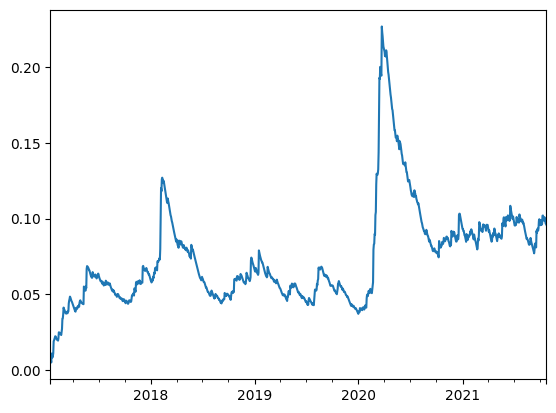

In [38]:
(res.portfolio_returns.ewm(halflife=21).std()*np.sqrt(252)).plot()

In [41]:
params2 = params
params2.gamma_risk = 1

In [107]:
results, duals = run_markowitz(
            full_markowitz,
            prices_train,
            spread_train,
            volume_train,
            rf_train,
            0.1/np.sqrt(252),
            params2,
            verbose=True,
        )

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

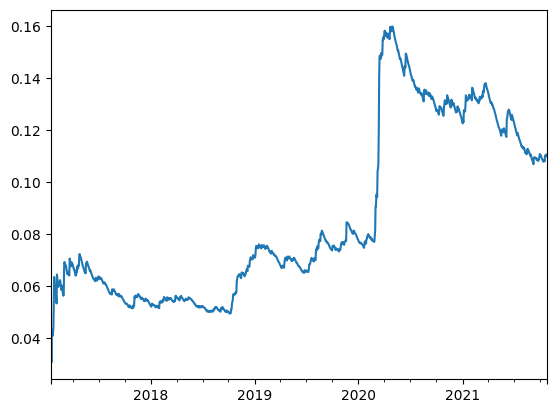

In [58]:
(results.portfolio_returns.ewm(halflife=63).std()*np.sqrt(252)).plot()

In [45]:
duals

,FullInvestment,Cash,CLower,CUpper,WLower,WUpper,ZLower,ZUpper,Leverage,Turnover,Risk
2017-01-11,-0.022493,-0.022493,0.0,0.044987,"[8.645497121924764e-11, 8.64822986322676e-11, ...","[5.800290108533934e-11, 5.799849478351272e-11,...","[1.7353178972992174e-10, 1.7420510911588984e-1...","[1.7260021333071972e-10, 1.7196232545446157e-1...",0.0,0.130603,0.0
2017-01-12,-0.0,0.0,0.0,0.0,"[5.018588651634246e-12, 5.022938163623848e-12,...","[3.4946538881237427e-12, 3.4908557875011e-12, ...","[9.587590432590033e-12, 9.602293370062933e-12,...","[9.586888282691358e-12, 9.577822572341868e-12,...",0.0,0.203461,0.0
2017-01-13,0.0,-0.0,0.0,0.0,"[1.515752557183404e-11, 1.514591080735209e-11,...","[1.0449990100511559e-11, 1.0460508939054161e-1...","[2.97196472835524e-11, 2.9618176977133126e-11,...","[2.9427945501515436e-11, 2.95060877016097e-11,...",0.0,0.235401,0.0
2017-01-16,-0.0,0.0,0.0,0.0,"[6.367283836479898e-12, 6.368442563105979e-12,...","[4.3978822845228444e-12, 4.3990596182824394e-1...","[1.2449143416888898e-11, 1.2441485308561364e-1...","[1.2399102256135143e-11, 1.2402581819105919e-1...",0.0,0.176878,0.0
2017-01-17,-0.0,0.0,0.0,0.0,"[1.809540445246482e-12, 1.8071270123336188e-12...","[1.2979713187599259e-12, 1.2990121049300156e-1...","[3.4446674918545197e-12, 3.4424426740040523e-1...","[3.4214121539083812e-12, 3.4251743379707055e-1...",0.0,0.169632,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
results.volatility

0.08998748651468831

In [35]:
duals.Risk.dropna().median()

3.7107741831158124e-07

In [34]:
2.0178709772998465e-06

2.0178709772998465e-06

In [20]:
params

HyperParameters(gamma_hold=1, gamma_trade=0.5, gamma_turn=0.4139728480824029, gamma_leverage=0.06763282443730048, gamma_risk=2.0178709772998465e-06)

In [22]:
res.volatility

0.08413656506603158

In [95]:
res = [*parameter_dict.values()][-1][1]

In [94]:
res = [*parameter_dict.values()][-1][1]

HyperParameters(gamma_hold=1.5, gamma_trade=0.5, gamma_turn=0.8298874131078795, gamma_leverage=5.100934264218233e-09, gamma_risk=18.116732358099316)

In [70]:
results.sharpe

0.5040844840830921

In [62]:
risk_target = 0.1 / np.sqrt(252)
hyperparameters = HyperParameters(
    0, 0, 0, 0, 0
)

results, duals = run_markowitz(
    strategy,
    prices,
    spread,
    volume,
    rf,
    risk_target,
    hyperparameters,
    verbose=True,
) 

Day 500 of 6190, 2001-12-04 00:00:00
Day 600 of 6190, 2002-04-23 00:00:00
Day 700 of 6190, 2002-09-10 00:00:00
Day 800 of 6190, 2003-01-28 00:00:00


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1395: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Day 900 of 6190, 2003-06-17 00:00:00
Day 1000 of 6190, 2003-11-04 00:00:00
Day 1100 of 6190, 2004-03-23 00:00:00
Day 1200 of 6190, 2004-08-10 00:00:00
Day 1300 of 6190, 2004-12-28 00:00:00
Day 1400 of 6190, 2005-05-17 00:00:00
Day 1500 of 6190, 2005-10-04 00:00:00
Day 1600 of 6190, 2006-02-21 00:00:00
Day 1700 of 6190, 2006-07-11 00:00:00
Day 1800 of 6190, 2006-11-28 00:00:00
Day 1900 of 6190, 2007-04-17 00:00:00
Day 2000 of 6190, 2007-09-04 00:00:00
Day 2100 of 6190, 2008-01-22 00:00:00
Day 2200 of 6190, 2008-06-10 00:00:00
Day 2300 of 6190, 2008-10-28 00:00:00
Day 2400 of 6190, 2009-03-17 00:00:00
Day 2500 of 6190, 2009-08-04 00:00:00
Day 2600 of 6190, 2009-12-22 00:00:00
Day 2700 of 6190, 2010-05-11 00:00:00
Day 2800 of 6190, 2010-09-28 00:00:00
Day 2900 of 6190, 2011-02-15 00:00:00
Day 3000 of 6190, 2011-07-05 00:00:00
Day 3100 of 6190, 2011-11-22 00:00:00
Day 3200 of 6190, 2012-04-10 00:00:00
Day 3300 of 6190, 2012-08-28 00:00:00
Day 3400 of 6190, 2013-01-15 00:00:00
Day 3500 of 6

In [63]:
print(f"mean: {results.mean_return}")
print(f"volatility: {results.volatility}")
print(f"max drawdown: {results.max_drawdown}")
print(f"max leverage: {results.max_leverage}")
print(f"sharpe: {results.sharpe}")
print(f"turnover: {results.turnover}")

mean: 0.04523447537467463
volatility: 0.08973590103046751
max drawdown: -0.2965556038964159
max leverage: 2.504314108737476
sharpe: 0.5040844840830921
turnover: 12.89692623810611


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

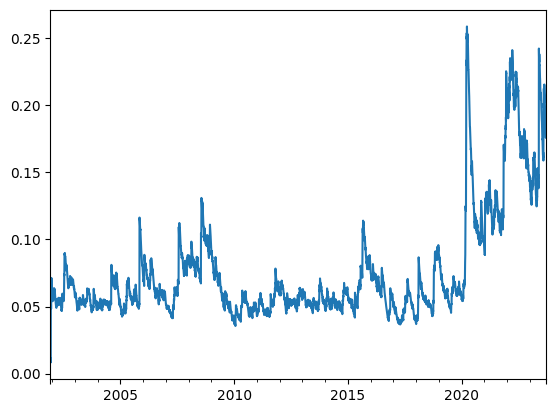

In [64]:
(results.portfolio_returns.ewm(halflife=21).std()*np.sqrt(252)).plot()

In [18]:
cons[0].name

'long_only'

In [3]:
t = returns.index[0]

prices_t = prices.loc[t]
returns_t = returns.loc[t]
spread_t = spread.loc[t]
volume_t = volume.loc[t]
rf_t = rf.loc[t]

Sigma_t = returns.cov()
mu_t = returns.mean()

risk_target = 0.1 / np.sqrt(252) 
T_max = 10 / 252
# T_max = 1

L_max = 1.6

In [4]:
def get_data_and_parameters(inputs, risk_target, T_max, L_max):

    n_assets = inputs.n_assets
    latest_prices = inputs.prices.iloc[-1]
    portfolio_value = inputs.cash + inputs.quantities @ latest_prices

    data = Data(
        w_prev=(inputs.quantities * latest_prices / portfolio_value),
        c_prev=(inputs.cash / portfolio_value),
        idio_mean=np.zeros(n_assets),
        factor_mean=inputs.mean.values,
        risk_free=0,
        factor_covariance_chol=np.linalg.cholesky(inputs.covariance.values),
        idio_volas=np.zeros(n_assets),
        F=np.eye(n_assets),
        kappa_short=np.zeros(n_assets),
        kappa_borrow=0.0,
        kappa_spread=np.zeros(n_assets),
        kappa_impact=np.zeros(n_assets),
    )

    param = Parameters(
        w_lower=-0.1,
        w_upper=0.15,
        c_lower=-0.3,
        c_upper=0.4,
        z_lower=-np.ones(data.n_assets) * 1e3,
        z_upper=np.ones(data.n_assets) * 1e3,
        T_max=T_max,
        L_max=L_max,
        rho_mean=np.zeros(data.n_assets),
        rho_covariance=0.0,
        gamma_hold=0.0,
        gamma_trade=0.0,
        gamma_turn=0.0,
        gamma_risk=0,
        risk_target=risk_target,
        gamma_c_lower=None,
        gamma_c_upper=None,
        gamma_w_lower=None,
        gamma_w_upper=None,
        gamma_z_lower=None,
        gamma_z_upper=None,
        gamma_L_max=None,
    )

    return data, param

def get_data_and_parameters2(inputs, gamma_risk, gamma_turn, gamma_c_lower, gamma_c_upper, gamma_w_lower, gamma_w_upper, gamma_z_lower, gamma_z_upper, gamma_L_max, risk_target, T_max, L_max=1.6):
                             
    n_assets = inputs.n_assets
    latest_prices = inputs.prices.iloc[-1]
    portfolio_value = inputs.cash + inputs.quantities @ latest_prices

    data = Data(
        w_prev=(inputs.quantities * latest_prices / portfolio_value),
        c_prev=(inputs.cash / portfolio_value),
        idio_mean=np.zeros(n_assets),
        factor_mean=inputs.mean.values,
        risk_free=0,
        factor_covariance_chol=np.linalg.cholesky(inputs.covariance.values),
        idio_volas=np.zeros(n_assets),
        F=np.eye(n_assets),
        kappa_short=np.zeros(n_assets),
        kappa_borrow=0.0,
        kappa_spread=np.zeros(n_assets),
        kappa_impact=np.zeros(n_assets),
    )

    # param = Parameters(
    #     w_lower=-0.1,
    #     w_upper=0.15,
    #     c_lower=-0.3,
    #     c_upper=0.4,
    #     z_lower=-np.ones(data.n_assets) * 1e3,
    #     z_upper=np.ones(data.n_assets) * 1e3,
    #     T_max=0,
    #     L_max=L_max,
    #     rho_mean=np.zeros(data.n_assets),
    #     rho_covariance=0.0,
    #     gamma_hold=0.0,
    #     gamma_trade=0.0,
    #     gamma_turn=gamma_turn,
    #     gamma_risk=gamma_risk,
    #     risk_target=inputs.risk_target,
    # )

    param = Parameters(
        w_lower=-0.1,
        w_upper=0.15,
        c_lower=-0.3,
        c_upper=0.4,
        z_lower=-np.ones(data.n_assets) * 1e3,
        z_upper=np.ones(data.n_assets) * 1e3,
        T_max=T_max,
        L_max=L_max,
        rho_mean=np.zeros(data.n_assets),
        rho_covariance=0.0,
        gamma_hold=0.0,
        gamma_trade=0.0,
        gamma_turn=gamma_turn,
        gamma_risk=gamma_risk,
        risk_target=inputs.risk_target,
        gamma_c_lower=gamma_c_lower,
        gamma_c_upper=gamma_c_upper,
        gamma_w_lower=gamma_w_lower,
        gamma_w_upper=gamma_w_upper,
        gamma_z_lower=gamma_z_lower,
        gamma_z_upper=gamma_z_upper,
        gamma_L_max=gamma_L_max,
    )

    

    return data, param


    

In [18]:
import time
import cvxpy as cp
def run_markowitz(
    # strategy: Callable, risk_target: float, verbose: bool = False,
    prices, spread, volume, rf, hard=True, verbose: bool = False,
) -> tuple[pd.Series, pd.DataFrame]:
    """
    Run a simplified backtest for a given strategy.
    At time t we use data from t-lookback to t to compute the optimal portfolio
    weights and then execute the trades at time t.
    """

    # prices, spread, volume, rf = load_data()
    n_assets = prices.shape[1]

    lookback = 500

    # Initialize quantities as equally weighted fully invested portfolio
    prices0 = prices.iloc[lookback]
    quantities = np.ones(n_assets) * (1 / prices0) / np.sum(1 / prices0)
    cash = 0

    post_trade_cash = []
    post_trade_quantities = []

    if hard:
        dual_optimals = pd.DataFrame(columns=["Risk", "Turnover", "CLower", "CUpper", "WUpper", "WLower", "ZUpper", "ZLower", "Leverage"], index=prices.index[lookback:-1])
    
    timings = []

    returns = prices.pct_change().dropna() 
    means = (
        synthetic_returns(prices, information_ratio=0.07).shift(-1).dropna()
    )  # At time t includes data up to t+1
    covariance_df = returns.ewm(halflife=125).cov()  # At time t includes data up to t
    days = returns.index
    covariances = {}
    for day in days:
        covariances[day] = covariance_df.loc[day]

    for t in range(lookback, len(prices) - 1):
        start_time = time.perf_counter()

        day = prices.index[t]

        if verbose and t%100 == 0:
            print(f"Day {t} of {len(prices)-1}, {day}")

        prices_t = prices.iloc[t - lookback : t + 1]  # Up to t
        spread_t = spread.iloc[t - lookback : t + 1]
        volume_t = volume.iloc[t - lookback : t + 1]

        mean_t = means.loc[day]  # Forecast for return t to t+1
        covariance_t = covariances[day]  # Forecast for covariance t to t+1

        inputs_t = OptimizationInput(
            prices_t,
            mean_t,
            covariance_t,
            spread_t,
            volume_t,
            quantities,
            cash,
            risk_target,
            rf.iloc[t],
        )

        data, param = get_data_and_parameters(inputs_t, risk_target, T_max, L_max)

        success = True
        try:
            w, _, problem = markowitz_hard(data, param)
        except (AssertionError, cp.SolverError) as e:
            print("Failed: removing T_max")
            data, param = get_data_and_parameters(inputs_t, risk_target, T_max=1e3, L_max=L_max)
            try :
                success = False
                w, _, problem = markowitz_hard(data, param)
            except (AssertionError, cp.SolverError) as f:
                print("Failed: removing L_max")
                # data, param = get_data_and_parameters(inputs_t, risk_target, T_max=1, L_max=3)
                # w, _, problem = markowitz_hard(data, param)


            

        latest_prices = prices.iloc[t]  # At t
        latest_spread = spread.iloc[t]

        cash += interest_and_fees(
            cash, rf.iloc[t - 1], quantities, prices.iloc[t - 1], day
        )
        trade_quantities = create_orders(w, quantities, cash, latest_prices)
        quantities += trade_quantities
        cash += execute_orders(latest_prices, trade_quantities, latest_spread)

        post_trade_cash.append(cash)
        post_trade_quantities.append(quantities.copy())
        dual_optimals.loc[day, "CLower"] = problem.constraints[2].dual_value
        dual_optimals.loc[day, "CUpper"] = problem.constraints[3].dual_value
        dual_optimals.loc[day, "WLower"] = problem.constraints[4].dual_value
        dual_optimals.loc[day, "WUpper"] = problem.constraints[5].dual_value
        dual_optimals.loc[day, "ZLower"] = problem.constraints[6].dual_value
        dual_optimals.loc[day, "ZUpper"] = problem.constraints[7].dual_value
        dual_optimals.loc[day, "Leverage"] = problem.constraints[8].dual_value
        if success:
            dual_optimals.loc[day, "Turnover"] = problem.constraints[9].dual_value
        else:
            try:
                dual_optimals.loc[day, "Turnover"] = dual_optimals.loc[prices.index[t-1], "Turnover"]
            except KeyError:
                dual_optimals.loc[day, "Turnover"] = problem.constraints[9].dual_value
        success = True
        dual_optimals.loc[day, "Risk"] = problem.constraints[10].dual_value

        # dual_optimals.append(problem.constraints[-1].dual_value)

        # Timings
        end_time = time.perf_counter()
        timings.append(Timing.get_timing(start_time, end_time, problem))

    post_trade_cash = pd.Series(post_trade_cash, index=prices.index[lookback:-1])
    post_trade_quantities = pd.DataFrame(
        post_trade_quantities, index=prices.index[lookback:-1], columns=prices.columns
    )

    return BacktestResult(post_trade_cash, post_trade_quantities, risk_target, timings), dual_optimals

####################
def run_soft_markowitz(
    prices, spread, volume, rf, priorities, verbose: bool = False,
) -> tuple[pd.Series, pd.DataFrame]:
    """
    Run a simplified backtest for a given strategy.
    At time t we use data from t-lookback to t to compute the optimal portfolio
    weights and then execute the trades at time t.
    """

    # prices, spread, volume, rf = load_data()
    n_assets = prices.shape[1]

    lookback = 500
    
    prices0 = prices.iloc[lookback]
    quantities = np.ones(n_assets) * (1 / prices0) / np.sum(1 / prices0)
    cash = 0

    post_trade_cash = []
    post_trade_quantities = []
    timings = []
    risks = pd.Series(index=prices.index[lookback:-1])
    turnovers = pd.Series(index=prices.index[lookback:-1])

    returns = prices.pct_change().dropna() 
    means = (
        synthetic_returns(prices, information_ratio=0.07).shift(-1).dropna()
    )  # At time t includes data up to t+1
    covariance_df = returns.ewm(halflife=125).cov()  # At time t includes data up to t
    days = returns.index
    covariances = {}
    for day in days:
        covariances[day] = covariance_df.loc[day]

    for t in range(lookback, len(prices) - 1):
        start_time = time.perf_counter()

        day = prices.index[t]

        if verbose and t%100 == 0:
            print(f"Day {t} of {len(prices)-1}, {day}")

        prices_t = prices.iloc[t - lookback : t + 1]  # Up to t
        spread_t = spread.iloc[t - lookback : t + 1]
        volume_t = volume.iloc[t - lookback : t + 1]

        mean_t = means.loc[day]  # Forecast for return t to t+1
        covariance_t = covariances[day]  # Forecast for covariance t to t+1

        inputs_t = OptimizationInput(
            prices_t,
            mean_t,
            covariance_t,
            spread_t,
            volume_t,
            quantities,
            cash,
            risk_target,
            rf.iloc[t],
        )

        gamma_risk=priorities.loc[day].Risk
        gamma_turn=priorities.loc[day].Turnover
        gamma_c_lower=priorities.loc[day].CLower
        gamma_c_upper=priorities.loc[day].CUpper
        gamma_w_lower=priorities.loc[day].WLower
        gamma_w_upper=priorities.loc[day].WUpper
        gamma_z_lower=priorities.loc[day].ZLower
        gamma_z_upper=priorities.loc[day].ZUpper
        gamma_L_max=priorities.loc[day].Leverage


        data, param = get_data_and_parameters2(inputs_t, 
                                               gamma_risk=gamma_risk, gamma_turn=gamma_turn, gamma_c_lower=gamma_c_lower, gamma_c_upper=gamma_c_upper, gamma_w_lower=gamma_w_lower, gamma_w_upper=gamma_w_upper, gamma_z_lower=gamma_z_lower, gamma_z_upper=gamma_z_upper, gamma_L_max=gamma_L_max, risk_target=risk_target, T_max=T_max, L_max=L_max)

        w, _, problem = markowitz(data, param)

        latest_prices = prices.iloc[t]  # At t
        latest_spread = spread.iloc[t]

        cash += interest_and_fees(
            cash, rf.iloc[t - 1], quantities, prices.iloc[t - 1], day
        )
        trade_quantities = create_orders(w, quantities, cash, latest_prices)
        quantities += trade_quantities
        cash += execute_orders(latest_prices, trade_quantities, latest_spread)

        post_trade_cash.append(cash)
        post_trade_quantities.append(quantities.copy())

        risk = np.sqrt(np.dot(np.dot(w, covariance_t), w)) * np.sqrt(252)
        turnover = np.sum(np.abs(w - data.w_prev))
        risks.loc[day] = risk
        turnovers.loc[day] = turnover

        # Timings
        end_time = time.perf_counter()
        timings.append(Timing.get_timing(start_time, end_time, problem))

    post_trade_cash = pd.Series(post_trade_cash, index=prices.index[lookback:-1])
    post_trade_quantities = pd.DataFrame(
        post_trade_quantities, index=prices.index[lookback:-1], columns=prices.columns
    )

    return BacktestResult(post_trade_cash, post_trade_quantities, risk_target, timings), risks, turnovers

In [19]:
results, duals = run_backtest(
    # strategy: Callable, risk_target: float, verbose: bool = False,
    prices, spread, volume, rf, True,
)

Day 500 of 6190, 2001-12-04 00:00:00
Failed: removing T_max
Day 600 of 6190, 2002-04-23 00:00:00
Failed: removing T_max
Day 700 of 6190, 2002-09-10 00:00:00
Failed: removing T_max
Failed: removing T_max
Day 800 of 6190, 2003-01-28 00:00:00
Failed: removing T_max
Failed: removing T_max
Day 900 of 6190, 2003-06-17 00:00:00
Day 1000 of 6190, 2003-11-04 00:00:00
Day 1100 of 6190, 2004-03-23 00:00:00
Day 1200 of 6190, 2004-08-10 00:00:00
Day 1300 of 6190, 2004-12-28 00:00:00
Day 1400 of 6190, 2005-05-17 00:00:00
Day 1500 of 6190, 2005-10-04 00:00:00
Day 1600 of 6190, 2006-02-21 00:00:00
Day 1700 of 6190, 2006-07-11 00:00:00
Day 1800 of 6190, 2006-11-28 00:00:00
Day 1900 of 6190, 2007-04-17 00:00:00
Day 2000 of 6190, 2007-09-04 00:00:00
Day 2100 of 6190, 2008-01-22 00:00:00
Failed: removing T_max
Failed: removing T_max
Day 2200 of 6190, 2008-06-10 00:00:00
Failed: removing T_max
Failed: removing T_max
Failed: removing T_max
Failed: removing T_max
Failed: removing T_max
Day 2300 of 6190, 2008

In [33]:
10/252 * 252

10.0

In [35]:
print(f"mean: {results.portfolio_returns.mean() * 252}")
print(f"volatility: {results.portfolio_returns.std() * np.sqrt(252)}")
print(f"max drawdown: {results.max_drawdown}")
print(f"max leverage: {results.max_leverage}")
print(f"sharpe: {results.sharpe}")
print(f"turnover: {results.turnover}")

mean: 0.09888883284649798
volatility: 0.10021556428044409
max drawdown: -0.21454040398029073
max leverage: 1.610985064846046
sharpe: 1.004084261845295
turnover: 18.549502794487584


In [69]:
print(f"mean: {results2.portfolio_returns.mean() * 252}")
print(f"volatility: {results2.portfolio_returns.std() * np.sqrt(252)}")
print(f"max drawdown: {results2.max_drawdown}")
print(f"max leverage: {results2.max_leverage}")
print(f"sharpe: {results2.sharpe}")
print(f"turnover: {results2.turnover}")

mean: 0.11898647918073932
volatility: 0.13668691122539112
max drawdown: -0.2630880870121153
max leverage: 1.9235078483587063
sharpe: 0.8857859130483625
turnover: 16.61892990122609


In [77]:
(4-2*np.sqrt(3))**2

0.2871870788979635

In [83]:
-72/38 + 20*(1-(37/38)**36) - 20 * (37/38)**36

2.790419081085642

In [76]:
print(f"mean: {results2.portfolio_returns.mean() * 252}")
print(f"volatility: {results2.portfolio_returns.std() * np.sqrt(252)}")
print(f"max drawdown: {results2.max_drawdown}")
print(f"max leverage: {results2.max_leverage}")
print(f"sharpe: {results2.sharpe}")
print(f"turnover: {results2.turnover}")

mean: 0.09231373957817875
volatility: 0.10606003538819855
max drawdown: -0.25982737580283366
max leverage: 2.3699631307778994
sharpe: 0.8856714835842171
turnover: 18.785408351372173


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

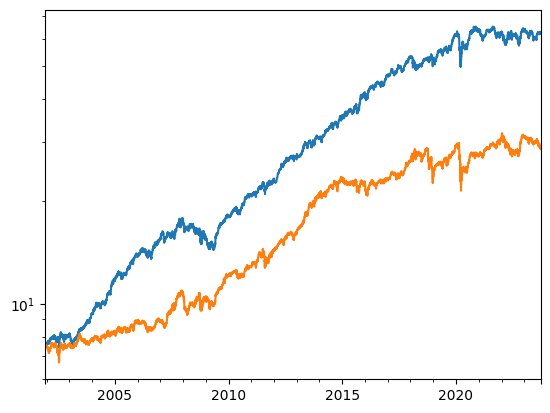

In [73]:
results.portfolio_value.plot()
results2.portfolio_value.plot()

plt.yscale("log")

In [13]:
print(f"mean: {results2.portfolio_returns.mean() * 252}")
print(f"volatility: {results2.portfolio_returns.std() * np.sqrt(252)}")
print(f"max drawdown: {results2.max_drawdown}")
print(f"max leverage: {results2.max_leverage}")
print(f"sharpe: {results2.sharpe}")

mean: 0.10672537668119053
volatility: 0.11644357518590612
max drawdown: -0.19847506847099672
max leverage: 2.983746552565785
sharpe: 0.9326318657509529


In [29]:
results2.portfolio_returns

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/experiments/backtest.py:224: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  return self.portfolio_value.pct_change().dropna()


Series([], dtype: float64)

In [62]:
# create dataframe where rows are duals.WUpper
Wupper = pd.DataFrame([duals.WUpper.values[i] for i in range(duals.shape[0])])
Wupper.index = duals.index
Wupper = Wupper.rolling(100, min_periods=1).quantile(0.8)
WLower = pd.DataFrame([duals.WLower.values[i] for i in range(duals.shape[0])])
WLower.index = duals.index
WLower = WLower.rolling(100, min_periods=1).quantile(0.8)

Zupper = pd.DataFrame([duals.ZUpper.values[i] for i in range(duals.shape[0])])
Zupper.index = duals.index
Zupper = Zupper.rolling(100, min_periods=1).quantile(0.8)
ZLower = pd.DataFrame([duals.ZLower.values[i] for i in range(duals.shape[0])])
ZLower.index = duals.index
ZLower = ZLower.rolling(100, min_periods=1).quantile(0.8)

In [74]:
priorities = pd.DataFrame(index = duals.index, columns=duals.columns)

for t in priorities.index:
    priorities.loc[t]["WUpper"] = Wupper.loc[t].values
    priorities.loc[t]["WLower"] = WLower.loc[t].values
    priorities.loc[t]["ZUpper"] = Zupper.loc[t].values * 0
    priorities.loc[t]["ZLower"] = ZLower.loc[t].values * 0

columns_remaining = ["Risk", "CLower", "CUpper"]
priorities[columns_remaining] = duals[columns_remaining].rolling(100, min_periods=1).quantile(0.99) 

priorities["Leverage"] = duals["Leverage"].rolling(100, min_periods=1).quantile(0.9)
priorities["Turnover"] = duals["Turnover"].rolling(100, min_periods=1).quantile(0.8)

In [18]:
0.00111194306017219 * 1000

1.11194306017219

In [75]:
results2, risks, turnovers = run_backtest2(
    # strategy: Callable, risk_target: float, verbose: bool = False,
    prices, spread, volume, rf, priorities.abs(), True
)

Day 500 of 6190, 2001-12-04 00:00:00
Day 600 of 6190, 2002-04-23 00:00:00
Day 700 of 6190, 2002-09-10 00:00:00
Day 800 of 6190, 2003-01-28 00:00:00
Day 900 of 6190, 2003-06-17 00:00:00
Day 1000 of 6190, 2003-11-04 00:00:00
Day 1100 of 6190, 2004-03-23 00:00:00
Day 1200 of 6190, 2004-08-10 00:00:00
Day 1300 of 6190, 2004-12-28 00:00:00
Day 1400 of 6190, 2005-05-17 00:00:00
Day 1500 of 6190, 2005-10-04 00:00:00
Day 1600 of 6190, 2006-02-21 00:00:00
Day 1700 of 6190, 2006-07-11 00:00:00
Day 1800 of 6190, 2006-11-28 00:00:00
Day 1900 of 6190, 2007-04-17 00:00:00
Day 2000 of 6190, 2007-09-04 00:00:00
Day 2100 of 6190, 2008-01-22 00:00:00
Day 2200 of 6190, 2008-06-10 00:00:00
Day 2300 of 6190, 2008-10-28 00:00:00
Day 2400 of 6190, 2009-03-17 00:00:00
Day 2500 of 6190, 2009-08-04 00:00:00
Day 2600 of 6190, 2009-12-22 00:00:00
Day 2700 of 6190, 2010-05-11 00:00:00
Day 2800 of 6190, 2010-09-28 00:00:00
Day 2900 of 6190, 2011-02-15 00:00:00
Day 3000 of 6190, 2011-07-05 00:00:00
Day 3100 of 6190,

In [68]:
returns

,T0,T1,T3,T4,T5,T6,T7,T8,T9,T10,...,T89,T90,T92,T93,T94,T95,T96,T98,T99,T100
2000-01-05,-0.025398,0.046893,0.060678,0.029942,-0.004416,0.026336,0.021299,0.041501,-0.018286,0.051260,...,0.019823,-0.003551,0.008401,0.020228,0.061013,0.054994,0.003040,-0.023089,0.057692,-0.003393
2000-01-06,0.021220,-0.010311,0.010249,0.044252,0.015084,0.041056,0.001100,-0.030361,0.045847,0.057275,...,0.029155,-0.003563,0.024993,0.026399,0.039316,-0.067926,0.017840,0.045790,-0.005188,0.044150
2000-01-07,0.013300,-0.003173,0.029033,0.032688,0.017481,0.016898,0.063595,-0.023483,-0.010956,-0.005125,...,0.073653,0.023816,0.043161,-0.023890,0.111840,0.020334,0.002893,0.028248,0.000000,0.017886
2000-01-10,0.014358,-0.005315,-0.014089,-0.032829,-0.017181,-0.026313,-0.029896,0.152305,-0.002769,-0.013982,...,-0.039578,0.030227,0.010344,0.009426,-0.004435,-0.003316,-0.040808,-0.012361,0.016973,-0.028758
2000-01-11,0.009299,-0.014956,-0.014326,-0.015756,-0.023602,-0.009245,0.034007,0.010434,-0.001394,0.011941,...,0.003662,-0.027083,-0.002526,-0.008410,0.005941,0.004999,-0.033434,-0.031988,0.050069,-0.019736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-20,-0.013304,0.005988,-0.010319,-0.003790,-0.004230,-0.003050,0.004469,0.007567,-0.016158,-0.007926,...,-0.009253,-0.011908,-0.004376,-0.002342,-0.013918,-0.008057,0.003856,-0.011112,-0.006130,-0.008098
2023-09-21,-0.016027,-0.009226,-0.011958,-0.023617,-0.007822,-0.008999,-0.015400,0.002059,-0.017331,-0.014089,...,-0.034250,-0.020008,-0.018636,-0.014019,-0.004085,0.006722,-0.022040,-0.016209,-0.026053,-0.012829
2023-09-22,-0.010536,-0.000300,-0.011203,0.003786,-0.009583,0.006598,0.001043,-0.017890,0.000756,0.001568,...,0.000745,-0.000570,0.000358,-0.010616,-0.002361,-0.010294,-0.009316,-0.006671,-0.008079,-0.025756
2023-09-25,0.000980,-0.003606,0.005412,0.004431,0.004941,0.014614,-0.010417,-0.002954,0.016029,0.011223,...,0.003179,0.009549,0.004029,0.003446,-0.003737,0.019958,-0.001813,-0.003969,-0.002752,0.008004


/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

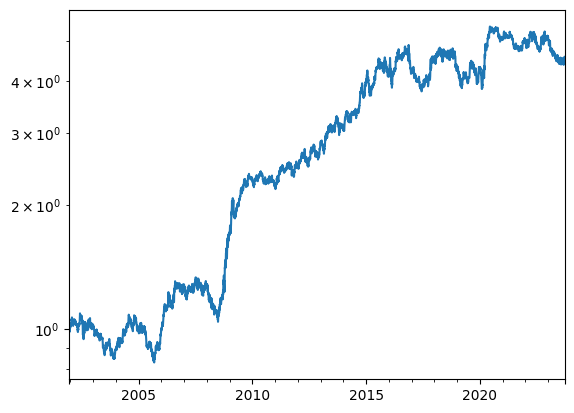

In [126]:
(results2.portfolio_value/results.portfolio_value).plot()
plt.yscale("log")

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

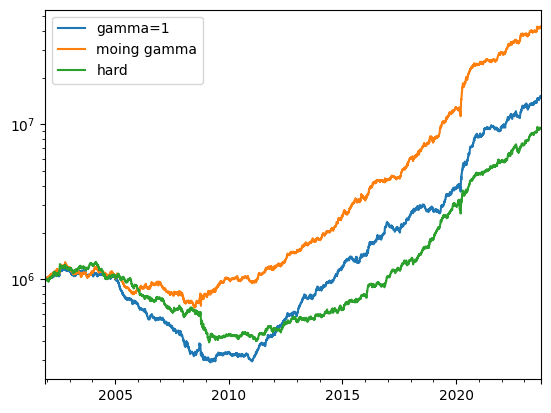

In [133]:
results3.portfolio_value.plot(label="gamma=1")
results2.portfolio_value.plot(label="moing gamma")
results.portfolio_value.plot(label="hard")
plt.legend()
plt.yscale("log")

/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/kasper/Documents/Stanford/Research/My papers/markowitz/reference_implementation/markowitz-reference/.venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.

<Axes: >

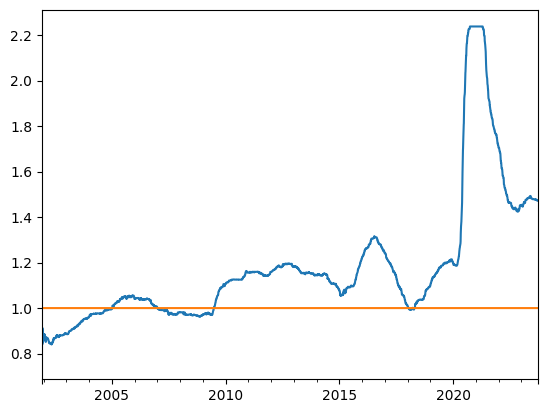

In [135]:
gamma_risks.plot()
gamma_risks3.plot()


In [122]:
(np.array(risks) <= 0.10).mean()

0.7769771528998243

In [116]:
print(f"mean: {results2.portfolio_returns.mean() * 252}")
print(f"volatility: {results2.portfolio_returns.std() * np.sqrt(252)}")
print(f"max drawdown: {results2.max_drawdown}")
print(f"max leverage: {results2.max_leverage}")
print(f"sharpe: {results2.sharpe}")

mean: 0.17344025387119444
volatility: 0.12064983093961906
max drawdown: -0.49037035995050804
max leverage: 7.550241878147584
sharpe: 1.4627875923226943


In [128]:
print(f"mean: {results3.portfolio_returns.mean() * 252}")
print(f"volatility: {results3.portfolio_returns.std() * np.sqrt(252)}")
print(f"max drawdown: {results3.max_drawdown}")
print(f"max leverage: {results3.max_leverage}")
print(f"sharpe: {results3.sharpe}")

mean: 0.12792709614439182
volatility: 0.12783809076710367
max drawdown: -0.756279240047702
max leverage: 7.62225670231688
sharpe: 1.0182639087089391


In [117]:
print(f"mean: {results.portfolio_returns.mean() * 252}")
print(f"volatility: {results.portfolio_returns.std() * np.sqrt(252)}")
print(f"max drawdown: {results.max_drawdown}")
print(f"max leverage: {results.max_leverage}")
print(f"sharpe: {results.sharpe}")

mean: 0.10690152368482325
volatility: 0.1249899715015102
max drawdown: -0.6974539553309929
max leverage: 7.222564873298741
sharpe: 0.8702956470609065


In [ ]:
results2

In [98]:
results.volatility

0.1271842267963638

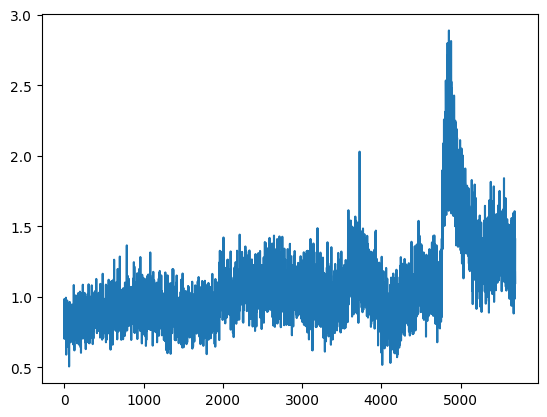

In [47]:
plt.plot(duals)